In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.0), torch.tensor(0.0))),
])

In [3]:
mnist = datasets.MNIST(root='./data', train=True, download=True)
val = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
new_dataset_images = []
new_dataset_labels = []

for i in range(10):
    images = [img for img, label in mnist if label == i][:1000]
    
    for img in images:
        img = img.resize((14, 14))
        img = transforms.ToTensor()(img)
        img = torch.where(img > 0.5, torch.tensor(1.0), torch.tensor(0.0))
        
        new_dataset_images.append(img)
        new_dataset_labels.append(i)

# Convert the lists to PyTorch tensors
new_dataset_images = torch.stack(new_dataset_images)
new_dataset_labels = torch.tensor(new_dataset_labels)

In [5]:
dataloader = DataLoader(list(zip(new_dataset_images, new_dataset_labels)), batch_size=32, shuffle=True)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 16)  # Outputs for both mean and logvar
        # Decoder
        self.fc3 = nn.Linear(8, 128)
        self.fc4 = nn.Linear(128, 196)

    def encode(self, x):
        h1 = torch.tanh(self.fc1(x))
        return self.fc2(h1).chunk(2, dim=1)  # Split the output into mu and logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 196))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [8]:
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters())
train_losses = []
BCE_losses = []
KLD_losses = []

for epoch in range(1, 51):
    autoencoder.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = autoencoder(data)
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        BCE_losses.append(BCE.item())
        KLD_losses.append(KLD.item())
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    train_losses.append(train_loss / len(dataloader.dataset))

====> Epoch: 1 Average loss: 58.7911
====> Epoch: 2 Average loss: 45.3630
====> Epoch: 3 Average loss: 42.1936
====> Epoch: 4 Average loss: 40.5899
====> Epoch: 5 Average loss: 39.4939
====> Epoch: 6 Average loss: 38.8471
====> Epoch: 7 Average loss: 38.3713
====> Epoch: 8 Average loss: 38.0005
====> Epoch: 9 Average loss: 37.6436
====> Epoch: 10 Average loss: 37.2553
====> Epoch: 11 Average loss: 36.9501
====> Epoch: 12 Average loss: 36.7360
====> Epoch: 13 Average loss: 36.4893
====> Epoch: 14 Average loss: 36.2325
====> Epoch: 15 Average loss: 36.0305
====> Epoch: 16 Average loss: 35.8812
====> Epoch: 17 Average loss: 35.7458
====> Epoch: 18 Average loss: 35.5644
====> Epoch: 19 Average loss: 35.4348
====> Epoch: 20 Average loss: 35.3394
====> Epoch: 21 Average loss: 35.1856
====> Epoch: 22 Average loss: 35.0829
====> Epoch: 23 Average loss: 35.0046
====> Epoch: 24 Average loss: 34.9274
====> Epoch: 25 Average loss: 34.8132
====> Epoch: 26 Average loss: 34.7967
====> Epoch: 27 Avera

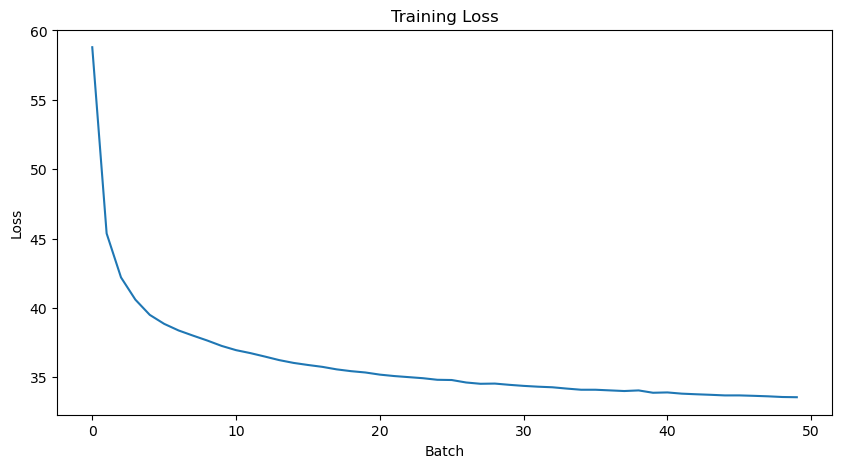

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

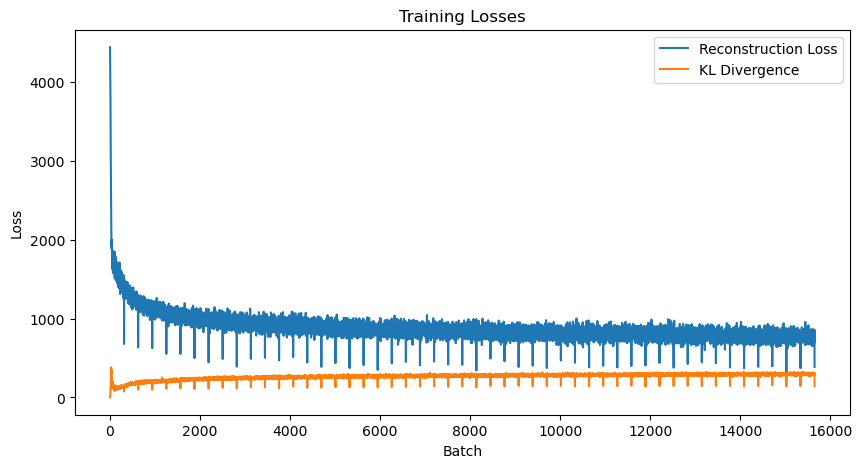

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(BCE_losses, label='Reconstruction Loss')
plt.plot(KLD_losses, label='KL Divergence')
plt.title("Training Losses")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

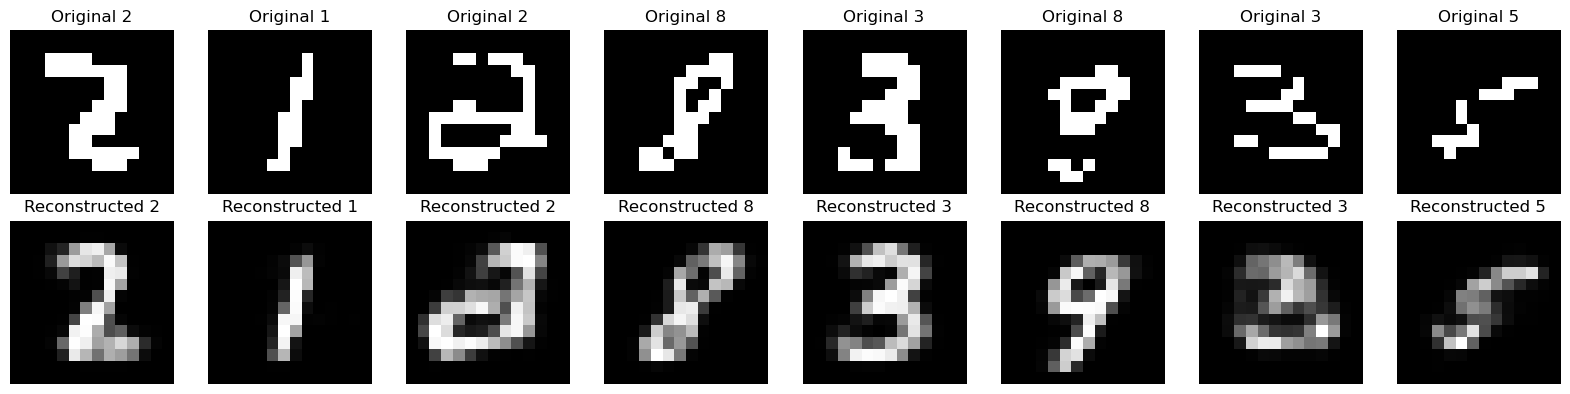

In [11]:
images, labels = next(iter(dataloader))
images = images[:8]
labels = labels[:8]

# Run the images through the autoencoder
recon_images, _, _ = autoencoder(images)

# Convert the images to numpy arrays
images = images.detach().numpy()
recon_images = recon_images.detach().numpy()

# Plot the original and reconstructed images side by side
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original images
    axs[0, i].imshow(images[i].reshape(14, 14), cmap='gray')
    axs[0, i].set_title(f'Original {labels[i]}')
    axs[0, i].axis('off')
    # Reconstructed images
    axs[1, i].imshow(recon_images[i].reshape(14, 14), cmap='gray')
    axs[1, i].set_title(f'Reconstructed {labels[i]}')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

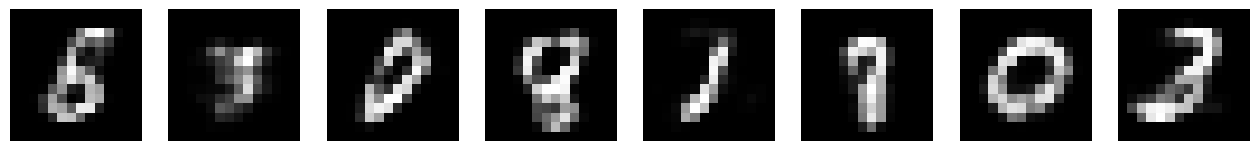

In [12]:
# Sample z from a standard Gaussian distribution
z = torch.randn(8, 8)

# Run the decoder network to synthesize an image
syn_images = autoencoder.decode(z)

# Convert the synthesized images to numpy arrays
syn_images = syn_images.detach().numpy()

# Plot the synthesized images
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

for i in range(8):
    axs[i].imshow(syn_images[i].reshape(14, 14), cmap='gray')
    axs[i].axis('off')

plt.show()

In [19]:
val_dataloader = DataLoader(val, batch_size=100, shuffle=True)

def validate(autoencoder, dataloader):
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            recon_batch, mu, logvar = autoencoder(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)
            val_loss += BCE.item() + KLD.item()
    return val_loss / len(dataloader.dataset)

all_train_losses = []
all_val_losses = []
update_count = 0

for epoch in range(1, 51):
    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = autoencoder(data)
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        all_train_losses.append(BCE.item()/len(dataloader))
        
        update_count += 1
        if update_count % 100 == 0:
            val_loss = validate(autoencoder, val_dataloader)
            all_val_losses.append(val_loss/len(val_dataloader))

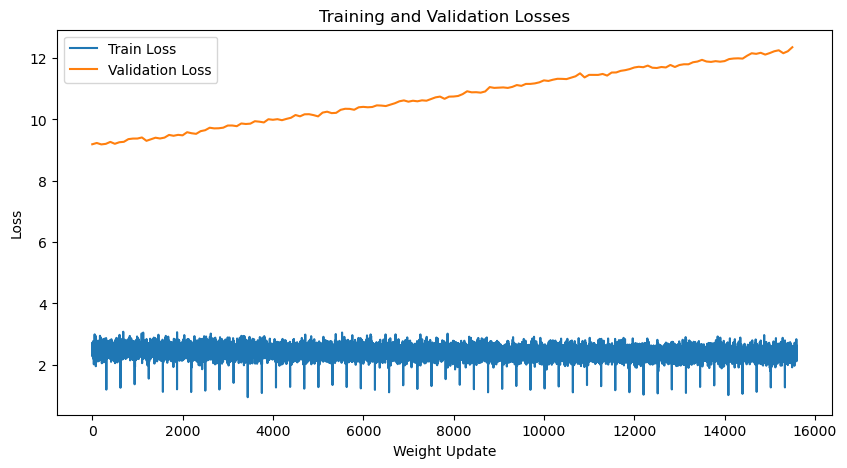

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(all_train_losses[:-50], label='Train Loss')  # Exclude the last value
plt.plot(range(0, len(all_train_losses[:-50]), 100), all_val_losses, label='Validation Loss')
plt.title("Training and Validation Losses")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.legend()
plt.show()